Adapted from : https://mne.tools/dev/auto_examples/simulation/simulate_evoked_data.html

In [23]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os.path as op
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import sample


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
if 'simulated-raw.fif' in os.listdir():
    raw = mne.io.read_raw_fif('simulated-raw.fif')
else:

    # For this example, we will be using the information of the sample subject.
    # This will download the data if it not already on your machine. We also set
    # the subjects directory so we don't need to give it to functions.
    data_path = sample.data_path()
    subjects_dir = op.join(data_path, 'subjects')
    subject = 'sample'

    # First, we get an info structure from the test subject.
    evoked_fname = op.join(data_path, 'MEG', subject, 'sample_audvis-ave.fif')
    info = mne.io.read_info(evoked_fname)
    tstep = 1. / info['sfreq']

    # To simulate sources, we also need a source space. It can be obtained from the
    # forward solution of the sample subject.
    fwd_fname = op.join(data_path, 'MEG', subject,
                        'sample_audvis-meg-eeg-oct-6-fwd.fif')
    fwd = mne.read_forward_solution(fwd_fname)
    src = fwd['src']

    source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)

    # To select a region to activate, we use the caudal middle frontal to grow
    # a region of interest.
    selected_label = mne.read_labels_from_annot(
        subject, regexp='inferiorparietal-lh', subjects_dir=subjects_dir)[0]
    location = 'center'  # Use the center of the region as a seed.
    extent = 10.  # Extent in mm of the region.
    label = mne.label.select_sources(
        subject, selected_label, location=location, extent=extent,
        subjects_dir=subjects_dir)

    # Define the time course of the activity for each source of the region to
    # activate. Here we use a sine wave at 10 Hz with a peak amplitude
    # of 10 nAm.
    source_time_series = np.sin(2. * np.pi * 10. * np.arange(25) * tstep) * 7e-9

    # Define when the activity occurs using events. The first column is the sample
    # of the event, the second is not used, and the third is the event id. Here the
    # events occur every 1000 samples.
    n_events = 200
    events = np.zeros((n_events, 3), int)
    events[:, 0] = 1000 * np.arange(n_events)  # Events sample.
    events[:, 2] = 1  # All events have the sample id.

    source_simulator.add_data(label, source_time_series, events)

    # add another source
    selected_label = mne.read_labels_from_annot(
        subject, regexp='superiorfrontal-lh', subjects_dir=subjects_dir)[0]
    location = 'center'  # Use the center of the region as a seed.
    extent = 10.  # Extent in mm of the region.
    label = mne.label.select_sources(
        subject, selected_label, location=location, extent=extent,
        subjects_dir=subjects_dir)

    source_time_series = np.sin(2. * np.pi * 10. * np.arange(25) * tstep) * 7e-9
    events2 = events.copy()
    events2[:,0] = events2[:,0] + 400
    events2[:,2] = 2
    source_simulator.add_data(label, source_time_series, events2)

    # and another
    selected_label = mne.read_labels_from_annot(
        subject, regexp='temporalpole-rh', subjects_dir=subjects_dir)[0]
    location = 'center'  # Use the center of the region as a seed.
    extent = 10.  # Extent in mm of the region.
    label = mne.label.select_sources(
        subject, selected_label, location=location, extent=extent,
        subjects_dir=subjects_dir)

    source_time_series = np.sin(2. * np.pi * 10. * np.arange(25) * tstep) * 7e-9
    events2 = events.copy()
    events2[:,0] = events2[:,0] + 300
    events2[:,2] = 2
    source_simulator.add_data(label, source_time_series, events2)
    
    # Project the source time series to sensor space and add some noise. The source
    # simulator can be given directly to the simulate_raw function.
    raw = mne.simulation.simulate_raw(info, source_simulator, forward=fwd, n_jobs=-1,verbose=False)
    cov = mne.make_ad_hoc_cov(raw.info)
    mne.simulation.add_noise(raw, cov, iir_filter=[0.2, -0.2, 0.04])
    #raw.plot()

    #raw.save('simulated-raw.fif')

    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading forward solution from /home/gweindel/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    MEG and EEG forward solutions combined
    Source spaces transformed to the forward solution coordinate frame
Reading labels fro

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Projections have already been applied. Setting proj attribute to True.


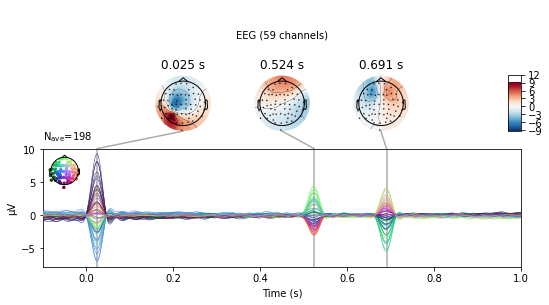

In [293]:
raw_ds = raw.load_data(verbose=False).copy()

tmin, tmax = -0.1, 1

raw_ds.filter(.5, 30, fir_design='firwin',verbose=False)
events = mne.find_events(raw_ds,verbose=False)

picks = mne.pick_types(raw_ds.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

epochs = mne.Epochs(raw_ds, events, 1, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True,
                    verbose=False,detrend=1)
epochs.average().plot_joint()
X = epochs.copy().get_data()

In [298]:
import xarray as xr
data = xr.Dataset(
            {
                "data": (["epochs", "electrodes", "samples"],X),
            },
            attrs={'sfreq':epochs.info['sfreq']}
            )
def vcov_mat(x):
    return x @ x.T

var_cov_matrices = []
for i,trial_dat in data.groupby('epochs'):
    var_cov_matrices.append(vcov_mat(trial_dat.data.to_numpy())) #Would be nice not to have a for loop but groupby.map seem to fal

average_var_cov_matrix = np.mean(var_cov_matrices,axis=0)

from sklearn.decomposition import PCA

pca = PCA(n_components=10, svd_solver='arpack')#selecting 10 Principale components (PC)
weights = pca.fit_transform(average_var_cov_matrix)

#Rebuilding pca PCs as xarray to ease computation
coords = dict(electrodes=("electrodes", data.coords["electrodes"].values),
             compoment=("component", np.arange(10)))
weights = xr.DataArray(weights, dims=("electrodes","component"), coords=coords)
pca_data = data.data @ weights

def zscore(x):
    data = x
    return (data - data.mean()) / data.std()
z_scored = pca_data.groupby('epochs').map(zscore)

import pyhsmm_mvpa as hsmm
stacked = z_scored.stack(all_samples=['epochs',"samples"]).dropna(dim="all_samples")
durations = np.unique(data.stack(trial=['epochs']).reset_index(['epochs']).groupby('trial').count(dim="samples").sel(electrodes=0).data.cumsum().to_numpy())
starts = np.insert(durations[:-1],0,0)
ends = durations-1

Estimating parameters for 3 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 3 bumps model


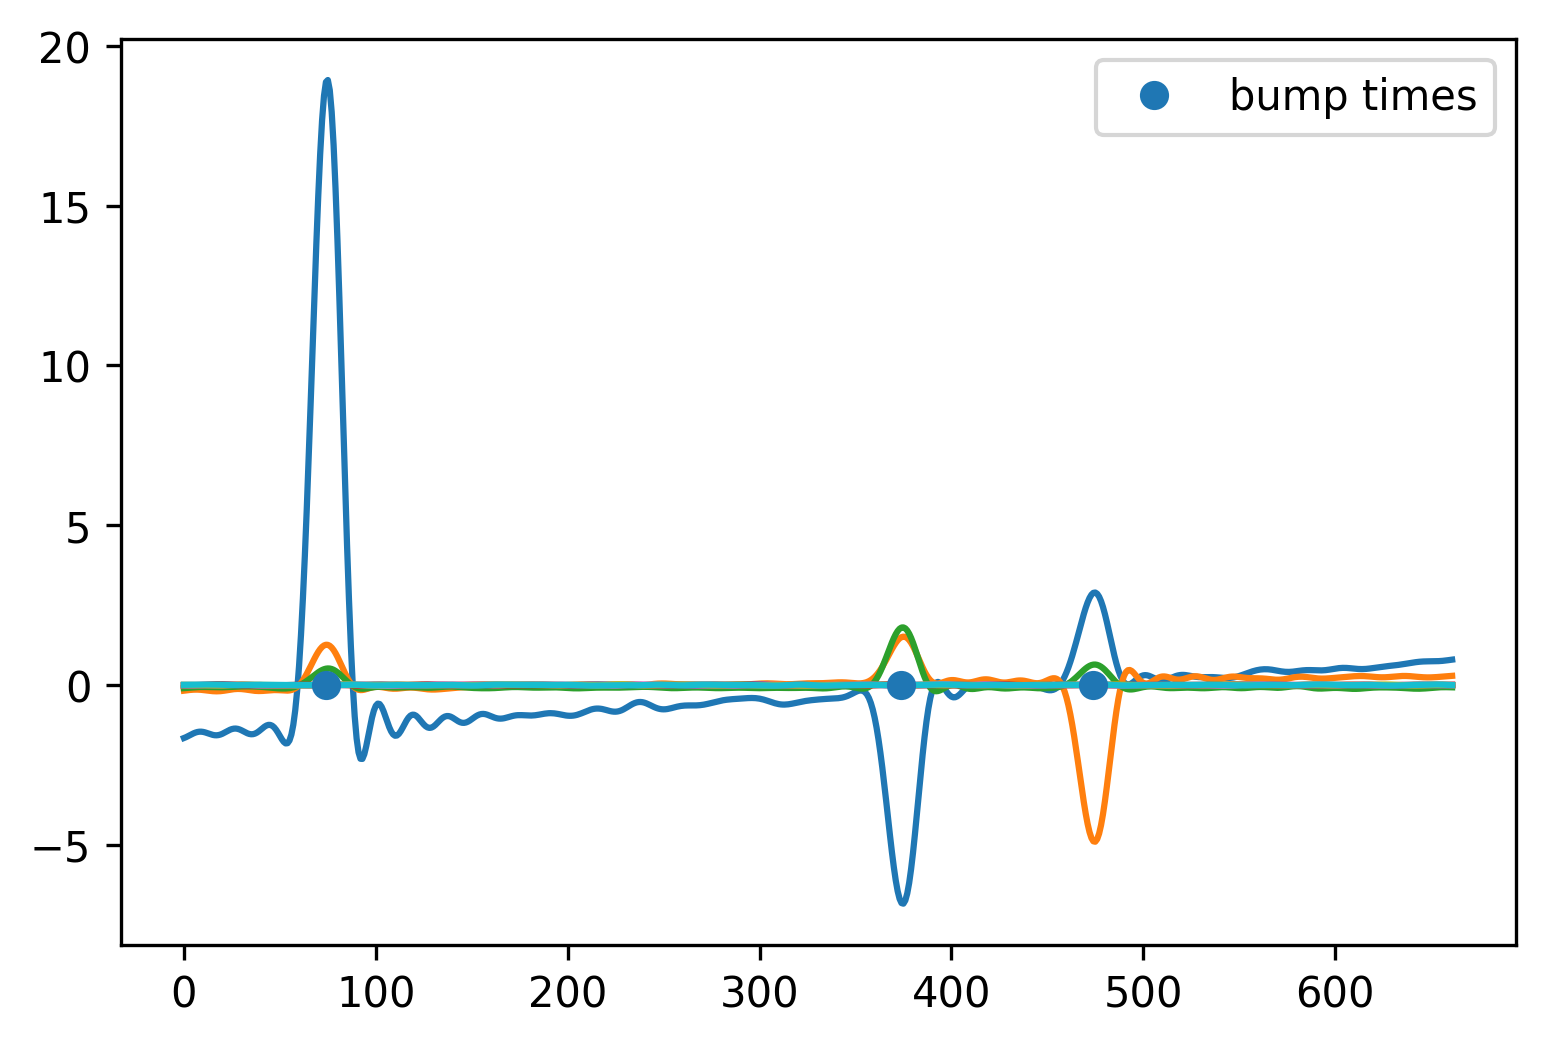

In [347]:
plt.figure(dpi=300)
init = hsmm.hsmm(stacked.to_numpy().T, starts, ends, sf=data.sfreq, bump_width=50)
estimates = init.fit_single(3)
times = init.bump_times(estimates, time=False)
for comp in np.arange(10):
    plt.plot(z_scored.mean(dim=['epochs'])[:,comp])
plt.plot(init.mean_bump_times(estimates,time=False), np.repeat(0,3),'o',label='Estimated bump times')
plt.legend();

Bump probability

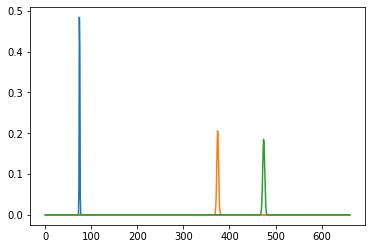

In [349]:
plt.plot(estimates.eventprobs.mean(dim=['trial']));

Bump topography

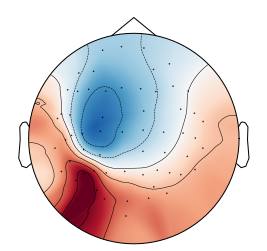

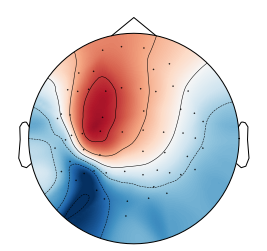

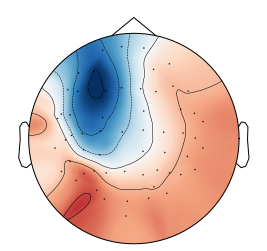

In [345]:
for bump in np.arange(3):
    mne.viz.plot_topomap(weights.data@estimates.magnitudes.sel(bump=bump).data, raw.info)

Iterative estimates

In [366]:
import multiprocessing

cpus = multiprocessing.cpu_count()

with multiprocessing.Pool(processes=cpus) as pool:
    iterative_results = pool.map(init.fit_single, np.arange(1,init.max_bumps()+1))
iterative_results = xr.concat(iterative_results, dim="n_bumps")
#For the single CPU automated version : init.fit_iterative(init.max_bumps())

Estimating parameters for 1 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 2 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 3 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 4 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 5 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 6 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 7 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 8 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 9 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 10 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 11 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 12 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 13 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 14 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 15 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 16 bumps model
Parameters estimated for 1 bumps model

/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:146: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:152: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')



Estimating parameters for 17 bumps model
Parameters estimated for 3 bumps model
Estimating parameters for 18 bumps model
Parameters estimated for 2 bumps model
Estimating parameters for 19 bumps model
Parameters estimated for 4 bumps model
Estimating parameters for 20 bumps model
Parameters estimated for 5 bumps model
Estimating parameters for 21 bumps model
Parameters estimated for 9 bumps model
Parameters estimated for 13 bumps model
Estimating parameters for 22 bumps model
Parameters estimated for 6 bumps model
Parameters estimated for 12 bumps model
Parameters estimated for 8 bumps model
Parameters estimated for 11 bumps model
Parameters estimated for 14 bumps model
Parameters estimated for 10 bumps model
Parameters estimated for 15 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 17 bumps model
Parameters estimated for 16 bumps model
Parameters estimated for 20 bumps model
Parameters estimated for 19 bumps model
Parameters estimated for 18 bumps model
P

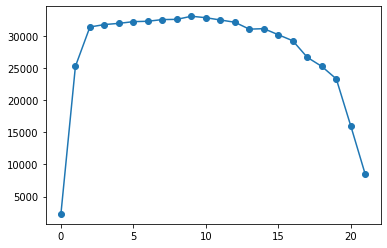

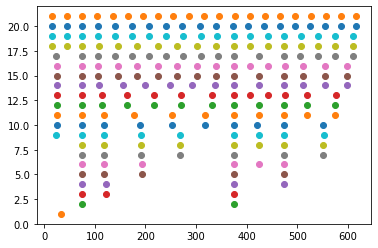

In [367]:
plt.plot(np.arange(init.max_bumps()), iterative_results.likelihoods,'o-')
plt.show()
for nbump in np.arange(init.max_bumps()):
    times = init.mean_bump_times(iterative_results.sel(n_bumps=nbump),time=False)
    plt.plot(times[:-1], np.repeat(nbump, len(times)-1),'o')


In [368]:
iterative_results.sel(n_bumps=9)

<xarray.Dataset>
Dimensions:      (stage: 23, params: 2, component: 10, bump: 22, samples: 662,
                  trial: 198)
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  float64 3.309e+04
    parameters   (stage, params) float64 2.0 16.16 2.0 17.16 ... nan nan nan nan
    magnitudes   (component, bump) float64 -2.184 16.69 -2.0 ... nan nan nan
    eventprobs   (samples, trial, bump) float64 0.0 0.0 0.0 0.0 ... nan nan nan

In [371]:
import itertools
bump_loo_results = [iterative_results.sel(n_bumps=10)]

i = 1
for n_bumps in np.arange(10-1,0,-1):
    temp_best = bump_loo_results[-i]
    n_bumps_list = np.arange(n_bumps+1)
    possible_bumps = list(itertools.combinations(n_bumps_list, n_bumps))
    possible_flats = list(itertools.combinations(n_bumps_list+1, n_bumps))
    possible_flats = [np.insert(x,0,0) for x in possible_flats]
    with multiprocessing.Pool(processes=cpus) as pool:
        bump_loo_likelihood_temp = pool.starmap(init.fit_single, 
            zip(itertools.repeat(n_bumps),temp_best.magnitudes.values.T[possible_bumps,:],
                temp_best.parameters.values[possible_flats,:],
                itertools.repeat(1),itertools.repeat(True)))
                #repeat(np.tile([1,50], (n_bumps,1))),
                #repeat(np.tile([2,12], (n_bumps,1)))))
    models = xr.concat(bump_loo_likelihood_temp, dim="iteration")
    bump_loo_results.append(models.sel(iteration=[np.where(models.likelihoods ==models.likelihoods.max())[0][0]]))
    i+=1
bests = xr.concat(bump_loo_results, dim="n_bumps")
bests = bests.assign_coords({"n_bumps": np.arange(10,0,-1)})
bests = bests.squeeze('iteration')
#bests.to_netcdf('bests.nc')
bests

Estimating parameters for 9 bumps model
Estimating parameters for 9 bumps model
Estimating parameters for 9 bumps model
Estimating parameters for 9 bumps model
Estimating parameters for 9 bumps model
Estimating parameters for 9 bumps model
Estimating parameters for 9 bumps model
Estimating parameters for 9 bumps model
Estimating parameters for 9 bumps model
Estimating parameters for 9 bumps model
Parameters estimated for 9 bumps model
Parameters estimated for 9 bumps model
Parameters estimated for 9 bumps model
Parameters estimated for 9 bumps model
Parameters estimated for 9 bumps model
Parameters estimated for 9 bumps model
Parameters estimated for 9 bumps model
Parameters estimated for 9 bumps model
Parameters estimated for 9 bumps model
Parameters estimated for 9 bumps model
Estimating parameters for 8 bumps model
Estimating parameters for 8 bumps model
Estimating parameters for 8 bumps model
Estimating parameters for 8 bumps model
Estimating parameters for 8 bumps model
Estimating

ValueError: conflicting sizes for dimension 'n_bumps': length 22 on 'n_bumps' and length 10 on {'n_bumps': 'likelihoods', 'iteration': 'likelihoods', 'stage': 'parameters', 'params': 'parameters', 'component': 'magnitudes', 'bump': 'magnitudes', 'samples': 'eventprobs', 'trial': 'eventprobs'}

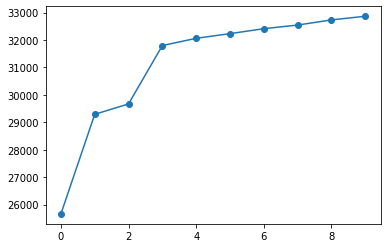

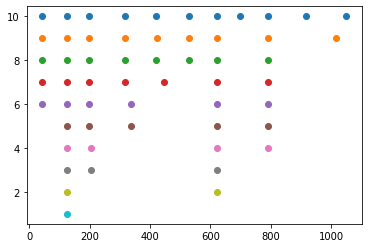

In [376]:
plt.plot(np.arange(10), bests.likelihoods[::-1],'o-')
plt.show()
for nbump in np.arange(10,0,-1):
    times = init.mean_bump_times(bests.sel(n_bumps=nbump))
    plt.plot(times, np.repeat(nbump, len(times)),'o')
